In [3]:

#PYTHON 3.11 PARA EL TKINTER

import numpy as np
import sounddevice as sd
import matplotlib.pyplot as plt
#import kbhit 
import time # para medir tiempos de ejecución
from tkinter import *

In [4]:
from osc import *

SRATE, CHUNK = 48000, 1024

In [6]:

# CLASE MODULADOR
class Modulator:
    def __init__(self, signal, freq=1, v0=0, v1=1):
            self.freq = freq
            self.frame = 0
            self.signal = signal
            self.osc = Osc(self.freq, v1-v0,self.frame+CHUNK)
            self.v0 = v0
            self.v1 = v1

            #genera una moduladora
            self.mod = Osc(freq)

    def next(self): 

        #se multiplican las señales
        out =((self.v1-self.v0)*self.mod.next()+(self.v1+self.v0))/2
        #
        #normaliza y reubica, el offset es para moverlo primero del [-1,1] al positivo
        #el /2 es para re escalar porque el rango ees de dos al principio y pasa a ser de 1

        self.frame += CHUNK
        return out * self.signal.next()


In [11]:
class Osc2:
    def __init__(self,freq=440.0,amp=1.0,phase=0.0):
        self.freq = freq
        self.amp = amp
        self.phase = phase
        self.frame = 0

    def next(self):    
        out = self.amp*np.sin(2*np.pi*(np.arange(self.frame,self.frame+CHUNK))*self.freq/SRATE)
        self.frame += CHUNK
        return out
    

    #frecuencia
    def getFreq(self):
        return self.freq
    
    def setFreq(self, newFreq):
        self.freq = newFreq

    #volumen
    def getAmp(self):
        return self.amp

    def setAmp(self, vol):
        self.amp = vol


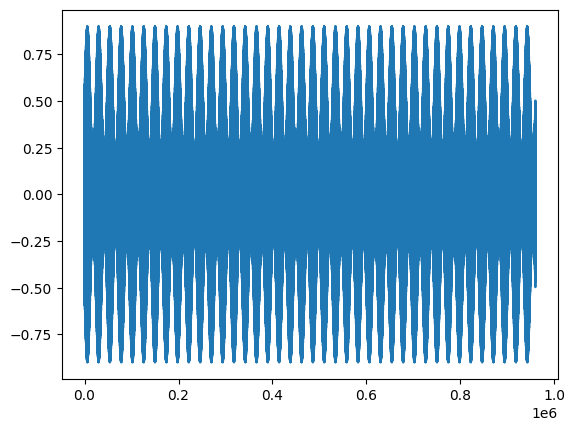

In [ ]:


# señal que vamos a modular
signal = Osc(freq=440)
# con un modulador de 2 Hz y amplitud en [0.2,0.9]
mod = Modulator(signal,freq=2,v0=.2,v1=.9)
# generamos 1.5 segundos de señal modulada
time = 20
chunks = int(time*SRATE/CHUNK) # número de chunks a generar
signal = np.empty(0) # acumulador de la señal
for i in range(chunks): # generamos los chunks
    signal = np.append(signal,mod.next())

sd.play(signal, SRATE)
sd.wait()
plt.plot(signal)

In [13]:

# señal que vamos a modular
signal = Osc2(freq=440)
# generamos 1.5 segundos de señal modulada
time = 3
chunks = int(time*SRATE/CHUNK) # número de chunks a generar

v = np.empty(0) # acumulador de la señal
for i in range(chunks): # generamos los chunks
    v = np.append(v,signal.next())

sd.play(v, SRATE)
sd.wait()

In [ ]:
def callback(outdata, farmes, time, status):
    v = np.zeros(0)
    for i in range(chunks):
        v = np.append(v, signal.next())
    sd.play(v)
    sd.wait()

# stream de salida con callBack
stream = sd.OutputStream(samplerate=SRATE, callback=callback, blocksize=CHUNK)
stream.start()

root=Tk()

text = Text(root,height=6,width=60)
text.pack(side=BOTTOM)
text.insert(INSERT,"V/v volume\n")


# call back para la pulsación de teclas
def key_down(event):
    global signal  # conexión con sounddevice
    if event.char=='v': 
        print('volume down')
        if signal.getAmp() > 0:
            signal.setAmp(signal.getAmp() - 0.1)
    elif event.char=='V': 
        print('volume up')
        if signal.getAmp() < 100:
            signal.setAmp(signal.getAmp() + 0.1)
        #input = Note(amp=0.6,release=2)  # enrutamos la señal de la nota al "input" del stream
    elif event.char=='f': 
        print('frecuency down')
        signal.setFreq(signal.getFreq() - 110)
    elif event.char=='F': 
        print('frecuency up')
        signal.setFreq(signal.getFreq() + 110)
    elif event.char==' ': 
        print('note deactivated')



text.bind('<Key>', key_down)



root.mainloop()
# ejecución bloqueada hasta que se cierre ventana

# limpieza..
stream.stop()
stream.close()